# Corona In Israel dataset

In [ ]:
import pandas as pd
import numpy as np
import pystan
import arviz
import matplotlib.pyplot as plt
import scipy.stats

## Data loading and exploration

In [201]:
corona = pd.read_csv('corona.csv')
corona.describe()

tests    positive
count    105.000000  105.000000
mean    9034.371429  224.152381
std     4462.792755  184.644085
min      717.000000    5.000000
25%     5878.000000   65.000000
50%     8572.000000  171.000000
75%    11757.000000  343.000000
max    19832.000000  738.000000

In [202]:
corona

date  tests  positive
0    2020-03-16T00:00:00.000Z   1345        73
1    2020-03-17T00:00:00.000Z   1647        94
2    2020-03-18T00:00:00.000Z   2108       118
3    2020-03-19T00:00:00.000Z   2074       135
4    2020-03-20T00:00:00.000Z   2321       168
..                        ...    ...       ...
100  2020-06-24T00:00:00.000Z  17696       466
101  2020-06-25T00:00:00.000Z  18457       504
102  2020-06-26T00:00:00.000Z  16547       464
103  2020-06-27T00:00:00.000Z  10488       398
104  2020-06-28T00:00:00.000Z   8572       299

[105 rows x 3 columns]

## Initial model


### we will examine 3 models:
all of the three are binomial models -
with the chance that a test will be positive $\theta$ that we will infer:
chance per day - each entry is observation <br>
<br>


In [ ]:
first_model = """
data {
    int<lower=0> N; // number of days
    int<lower=0> p[N]; // number of positives in specific day
    int<lower=0> t[N];// number of tests in specific day
}

parameters {
    real<lower=0, upper=1> theta; // the latent variable we want to infer
}


model {
    theta ~ beta(0.1, 0.9); // beta prior, with some basic knowledge domain
    for (i in 1:N){
        target += binomial_lpmf(p[i] | t[i] , theta);
    }
    
}
"""

In [ ]:
compiled_model = pystan.StanModel(model_code=first_model)

In [ ]:
t = corona['tests'].to_numpy()
p = corona['positive'].to_numpy()
N = len(t)

In [ ]:
data = {'N':N, 't': t, 'p': p}

In [ ]:
fit = compiled_model.sampling(data=data, chains=4)

_ = arviz.plot_trace(fit)

In [ ]:
print(fit)

## Check The Model

we will check the predictive posterior and compare to the dataset.<br>
we will look at the difference for each day - we will make $k_d$ expirments where d is specific day and k is number of expirments in this same day.

In [ ]:
def draw_positve(theta, N):
    # return bimomial results
    return np.random.binomial(N, theta)
    

In [ ]:
def simulate(t , theta):
    return list(map(lambda N: draw_positve(theta,N), t))

In [ ]:
fig, ax = plt.subplots()
ax.set_title('values distribution')
ax.set_xlabel("values")
ax.set_ylabel('count')
ax.hist(p, label="data")
for j in range(3):
    ax.hist(simulate(t, np.mean(fit['theta'])), alpha=0.33, label="simulation "+str(j+1))
ax.legend()

### lets make another plot with plot per day

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
ax.set_title('num of positives over time')
ax.set_xlabel("day")
ax.set_ylabel('num of positives')
ax.plot(p, label="data")
for j in range(20):
    ax.plot(simulate(t, np.mean(fit['theta'])), alpha=0.33, label="simulation "+str(j+1))
ax.legend()

In [ ]:
fig, ax = plt.subplots(1 , 2)
ax[0].set_title('difference between predictive posterior and data')
ax[0].set_xlabel("day")
ax[0].set_ylabel('difference')
ax[-1].set_title('difference (with abs) between predictive posterior and data')
ax[-1].set_xlabel("day")
ax[-1].set_ylabel('difference (with abs)')
for j in range(3):
    simulation_j = simulate(t, np.mean(fit['theta']))
    ax[0].plot(p - simulation_j, alpha=0.33, label="simulation "+str(j+1))
    ax[-1].plot(np.abs(p - simulation_j), alpha=0.33, label="simulation "+str(j+1))
ax[0].legend()
_ = ax[-1].legend()

### we can see visually that the model is not describing the data good enough

## p-values tests

In [ ]:
dataMin, dataMax, dataMedian = p.min(), p.max(), np.median(p)
dataStd, dataMean = np.std(p) , np.mean(p)

In [ ]:
NSIM = 300
fig, ax = plt.subplots(1, 5, figsize=(18, 9))
ax[0].set_xlabel("min")
ax[1].set_xlabel("max")
ax[2].set_xlabel("median")
ax[3].set_xlabel("std")
min_max_median_std_mean = []
for j in range(NSIM):
    y = np.array(simulate(t, np.mean(fit['theta'])))
    min_max_median_std_mean.append([y.min(), y.max(), np.median(y), np.std(y), np.mean(y)])
min_max_median_std_mean = np.array(min_max_median_std_mean)

# plot data values of test variables as vertical red lines
ax[0].axvline(dataMin, color="red")
ax[1].axvline(dataMax, color="red")
ax[2].axvline(dataMedian, color="red")
ax[3].axvline(dataStd, color="red")
ax[4].axvline(dataMean, color="red")
# plot sampled values of test values as histograms
for j in range(5):
    ax[j].hist(min_max_median_std_mean[:, j], zorder=-1)

# compute p-values and display them as subplot titles
ax[0].set_title("p-value = {:.2f}".format(
    len(min_max_median_std_mean[:, 0][min_max_median_std_mean[:, 0] < dataMin]) /
    len(min_max_median_std_mean)))
ax[1].set_title("p-value = {:.2f}".format(
    len(min_max_median_std_mean[:, 1][min_max_median_std_mean[:, 1] > dataMax]) /
    len(min_max_median_std_mean)))
ax[2].set_title("p-value = {:.2f}".format(
    len(min_max_median_std_mean[:, 2][min_max_median_std_mean[:, 2] < dataMedian]) /
    len(min_max_median_std_mean)))
ax[3].set_title("p-value = {:.2f}".format(
    len(min_max_median_std_mean[:, 3][min_max_median_std_mean[:, 3] < dataStd]) /
    len(min_max_median_std_mean)))
ax[4].set_title("p-value = {:.2f}".format(
    len(min_max_median_std_mean[:, 4][min_max_median_std_mean[:, 4] < dataMean]) /
    len(min_max_median_std_mean)))

## we can see the results are good only in the mean test and realy bad at all of the rest. 
current checking is on number of positives , maybe we should normalize and look on percantages

In [ ]:
ratio = p / t

In [ ]:
dataMin, dataMax, dataMedian = ratio.min(), ratio.max(), np.median(ratio)
dataStd, dataMean = np.std(ratio) , np.mean(ratio)

In [ ]:
NSIM = 300
fig, ax = plt.subplots(1, 5, figsize=(18, 9))
ax[0].set_xlabel("min")
ax[1].set_xlabel("max")
ax[2].set_xlabel("median")
ax[3].set_xlabel("std")
min_max_median_std_mean = []
for j in range(NSIM):
    y = np.array(simulate(t, np.mean(fit['theta'])) / t)
    min_max_median_std_mean.append([y.min(), y.max(), np.median(y), np.std(y), np.mean(y)])
min_max_median_std_mean = np.array(min_max_median_std_mean)

# plot data values of test variables as vertical red lines
ax[0].axvline(dataMin, color="red")
ax[1].axvline(dataMax, color="red")
ax[2].axvline(dataMedian, color="red")
ax[3].axvline(dataStd, color="red")
ax[4].axvline(dataMean, color="red")
# plot sampled values of test values as histograms
for j in range(5):
    ax[j].hist(min_max_median_std_mean[:, j], zorder=-1)

# compute p-values and display them as subplot titles
ax[0].set_title("p-value = {:.2f}".format(
    len(min_max_median_std_mean[:, 0][min_max_median_std_mean[:, 0] < dataMin]) /
    len(min_max_median_std_mean)))
ax[1].set_title("p-value = {:.2f}".format(
    len(min_max_median_std_mean[:, 1][min_max_median_std_mean[:, 1] > dataMax]) /
    len(min_max_median_std_mean)))
ax[2].set_title("p-value = {:.2f}".format(
    len(min_max_median_std_mean[:, 2][min_max_median_std_mean[:, 2] < dataMedian]) /
    len(min_max_median_std_mean)))
ax[3].set_title("p-value = {:.2f}".format(
    len(min_max_median_std_mean[:, 3][min_max_median_std_mean[:, 3] < dataStd]) /
    len(min_max_median_std_mean)))
ax[4].set_title("p-value = {:.2f}".format(
    len(min_max_median_std_mean[:, 4][min_max_median_std_mean[:, 4] < dataMean]) /
    len(min_max_median_std_mean)))

### still not good results. let's try to improve the model

## Improvment Ideas

## make hierarchical models - with different $\theta$'s:<br>
we should think on the distribution of the hyperparameters
1) each day with different $\theta_i$<br>
2) each week with different $\theta_i$ - we can't see from the data the their is disguinshed change between weeks<br>
3) each two-weeks with different $\theta_i$ - same as previous one

### 1) each day with different $\theta_i$<br>

In [168]:
second_model = """
data {
    int<lower=0> N; // number of days
    int<lower=0> p[N]; // number of positives in specific day
    int<lower=0> t[N];// number of tests in specific day
}

parameters {
    real<lower=0, upper=1> theta; // the latent variable we want to infer
    real<lower=0, upper=1> sigma; // the latent variable we want to infer
    real<lower=0, upper=1> theta_per_day[N];
}



model {
    sigma ~ normal(0,0.001);
    theta ~ beta(0.1, 0.9);
     // beta prior, with some basic knowledge domain
    for (i in 1:N){
        theta_per_day[i] ~ normal(theta, sigma);
        target += binomial_lpmf(p[i] | t[i] , theta_per_day[i]);
    }
    
}
"""

In [169]:
compiled_model = pystan.StanModel(model_code=second_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9a054ebaa4431fac6aa37d9eb88c01ea NOW.


Inference for Stan model: anon_model_9a054ebaa4431fac6aa37d9eb88c01ea.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean      sd   2.5%    25%    50%     75%  97.5%  n_eff   Rhat
theta                0.03  1.4e-5  1.4e-3   0.03   0.03   0.03    0.03   0.03  10575    1.0
sigma                0.01  4.8e-6  4.5e-4   0.01   0.01   0.01    0.01   0.02   8952    1.0
theta_per_day[1]     0.05  4.4e-5  5.0e-3   0.04   0.05   0.05    0.06   0.06  13035    1.0
theta_per_day[2]     0.05  4.4e-5  4.5e-3   0.04   0.05   0.05    0.06   0.06  10645    1.0
theta_per_day[3]     0.06  4.5e-5  4.9e-3   0.05   0.06   0.06    0.06   0.07  11645    1.0
theta_per_day[4]     0.07  4.4e-5  4.7e-3   0.06   0.06   0.07    0.07   0.08  11595    1.0
theta_per_day[5]     0.09  5.6e-5  5.4e-3   0.08   0.09   0.09    0.09    0.1   9410    1.0
theta_per_day[6]     0.07  3.9e-5  4.2e-3   0.06   0.07   0.07    0.07   0.

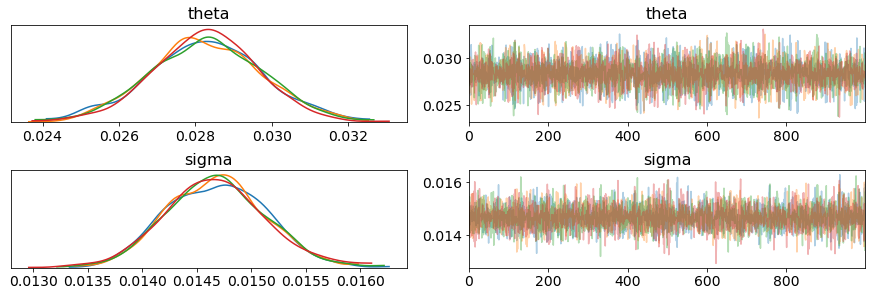

In [174]:
second_fit = compiled_model.sampling(data={'N':len(p), 'p':p, 't':t}, chains=4, control = {'adapt_delta':0.9})
print(second_fit)
_ = arviz.plot_trace(second_fit, var_names=['theta','sigma'])

In [175]:
def simulate2(theta_per_day, t):
    return list(map(lambda theta, N: draw_positve(theta,N), theta_per_day, t))

In [192]:
def simulate_with_hyper_params(mean_theta, noise):
    simulated_theta = np.random.normal(mean_theta, noise)
    return simulated_theta

In [176]:
theta_per_day = np.mean(second_fit.extract()['theta_per_day'], axis=0)

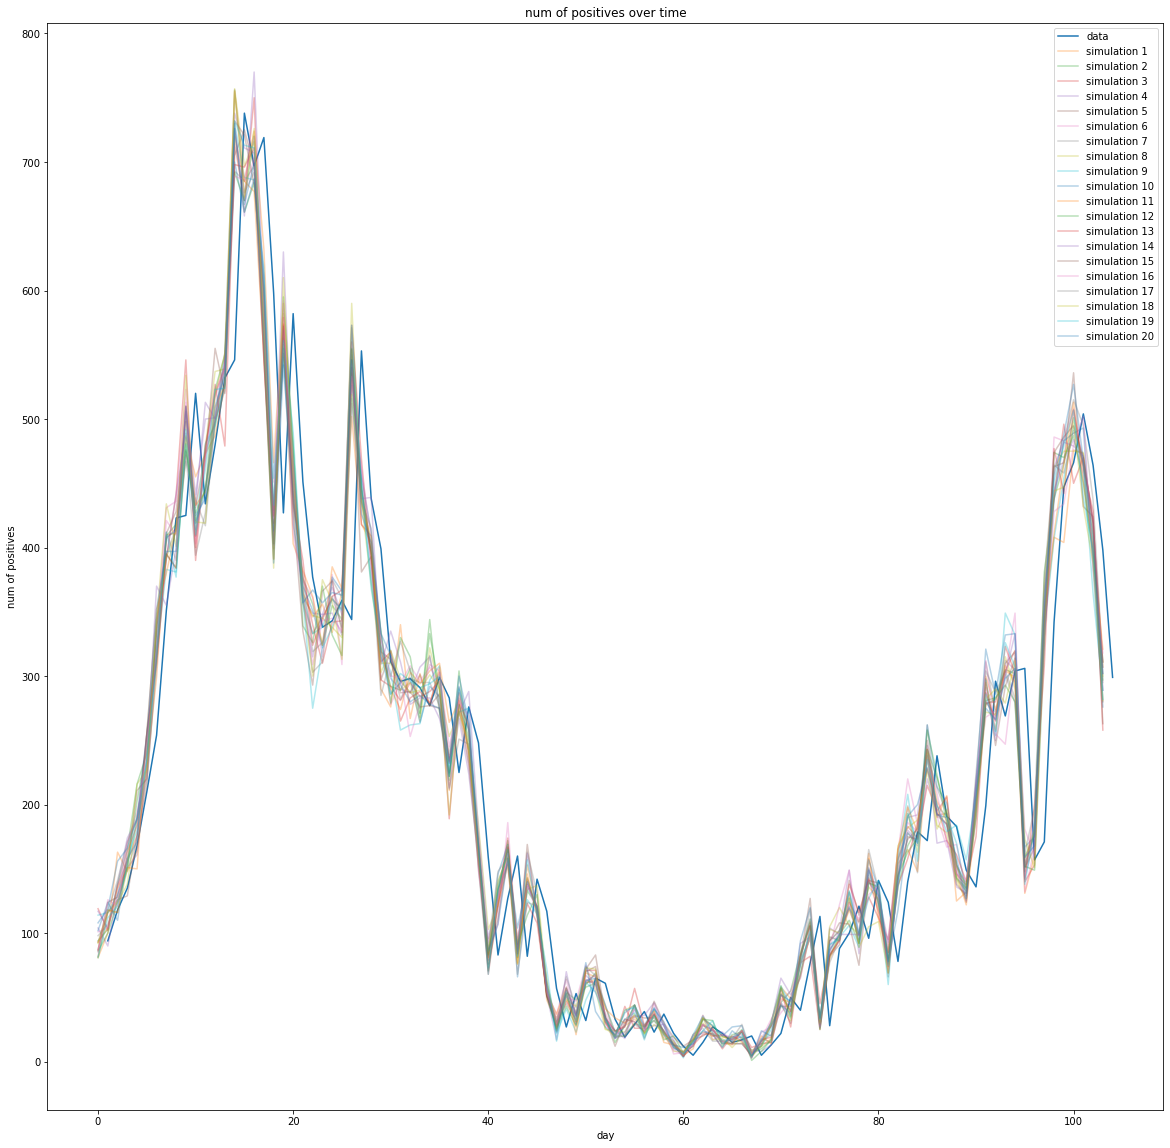

In [177]:
fig, ax = plt.subplots(figsize=(20,20))
ax.set_title('num of positives over time')
ax.set_xlabel("day")
ax.set_ylabel('num of positives')
ax.plot(p, label="data")
for j in range(20):
    ax.plot(simulate2(theta_per_day, t), alpha=0.33, label="simulation "+str(j+1))
ax.legend()

when we use the learned $\theta_i$ this is a clear overfit. we should geneare each time from $\theta$ and $\sigma$

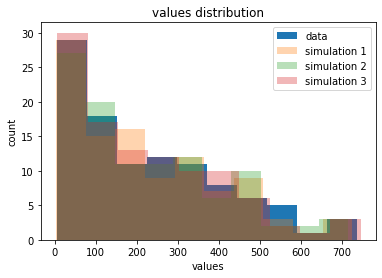

In [178]:
fig, ax = plt.subplots()
ax.set_title('values distribution')
ax.set_xlabel("values")
ax.set_ylabel('count')
ax.hist(p, label="data")
for j in range(3):
    ax.hist(simulate2(theta_per_day, t), alpha=0.33, label="simulation "+str(j+1))
ax.legend()

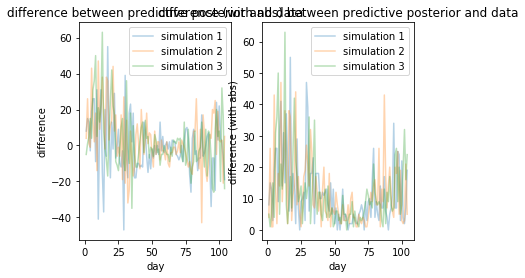

In [179]:
fig, ax = plt.subplots(1 , 2)
ax[0].set_title('difference between predictive posterior and data')
ax[0].set_xlabel("day")
ax[0].set_ylabel('difference')
ax[-1].set_title('difference (with abs) between predictive posterior and data')
ax[-1].set_xlabel("day")
ax[-1].set_ylabel('difference (with abs)')
for j in range(3):
    simulation_j = simulate2(theta_per_day, t)
    ax[0].plot(p - simulation_j, alpha=0.33, label="simulation "+str(j+1))
    ax[-1].plot(np.abs(p - simulation_j), alpha=0.33, label="simulation "+str(j+1))
ax[0].legend()
ax[-1].legend()

In [180]:
dataMin, dataMax, dataMedian = p.min(), p.max(), np.median(p)
dataStd, dataMean = np.std(p) , np.mean(p)

In [181]:
NSIM = 300
fig, ax = plt.subplots(1, 5, figsize=(18, 9))
ax[0].set_xlabel("min")
ax[1].set_xlabel("max")
ax[2].set_xlabel("median")
ax[3].set_xlabel("std")
ax[4].set_xlabel("mean")
min_max_median_std_mean = []
for j in range(NSIM):
    y = np.array(simulate2(theta_per_day, t))
    min_max_median_std_mean.append([y.min(), y.max(), np.median(y), np.std(y), np.mean(y)])
min_max_median_std_mean = np.array(min_max_median_std_mean)

# plot data values of test variables as vertical red lines
ax[0].axvline(dataMin, color="red")
ax[1].axvline(dataMax, color="red")
ax[2].axvline(dataMedian, color="red")
ax[3].axvline(dataStd, color="red")
ax[4].axvline(dataMean, color="red")
# plot sampled values of test values as histograms
for j in range(5):
    ax[j].hist(min_max_median_std_mean[:, j], zorder=-1)

# compute p-values and display them as subplot titles
ax[0].set_title("p-value = {:.2f}".format(
    len(min_max_median_std_mean[:, 0][min_max_median_std_mean[:, 0] < dataMin]) /
    len(min_max_median_std_mean)))
ax[1].set_title("p-value = {:.2f}".format(
    len(min_max_median_std_mean[:, 1][min_max_median_std_mean[:, 1] > dataMax]) /
    len(min_max_median_std_mean)))
ax[2].set_title("p-value = {:.2f}".format(
    len(min_max_median_std_mean[:, 2][min_max_median_std_mean[:, 2] < dataMedian]) /
    len(min_max_median_std_mean)))
ax[3].set_title("p-value = {:.2f}".format(
    len(min_max_median_std_mean[:, 3][min_max_median_std_mean[:, 3] < dataStd]) /
    len(min_max_median_std_mean)))
ax[4].set_title("p-value = {:.2f}".format(
    len(min_max_median_std_mean[:, 4][min_max_median_std_mean[:, 4] < dataMean]) /
    len(min_max_median_std_mean)))

Text(0.5, 1.0, 'p-value = 0.90')

In [182]:
dataMin, dataMax, dataMedian = ratio.min(), ratio.max(), np.median(ratio)
dataStd, dataMean = np.std(ratio) , np.mean(ratio)

Text(0.5, 1.0, 'p-value = 1.00')

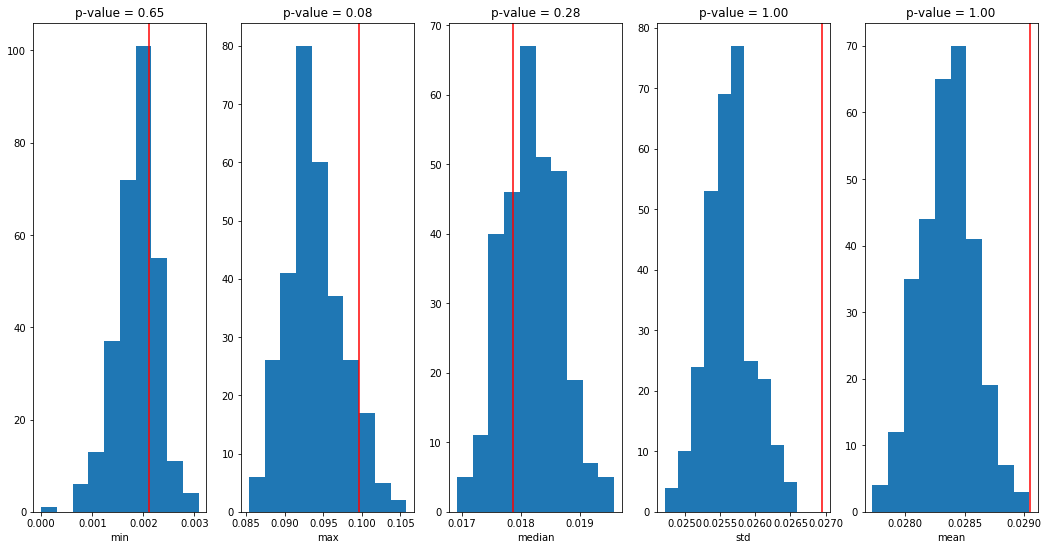

In [183]:
NSIM = 300
fig, ax = plt.subplots(1, 5, figsize=(18, 9))
ax[0].set_xlabel("min")
ax[1].set_xlabel("max")
ax[2].set_xlabel("median")
ax[3].set_xlabel("std")
ax[4].set_xlabel("mean")
min_max_median_std_mean = []
for j in range(NSIM):
    y = np.array(simulate2(theta_per_day, t)) / t
    min_max_median_std_mean.append([y.min(), y.max(), np.median(y), np.std(y), np.mean(y)])
min_max_median_std_mean = np.array(min_max_median_std_mean)

# plot data values of test variables as vertical red lines
ax[0].axvline(dataMin, color="red")
ax[1].axvline(dataMax, color="red")
ax[2].axvline(dataMedian, color="red")
ax[3].axvline(dataStd, color="red")
ax[4].axvline(dataMean, color="red")
# plot sampled values of test values as histograms
for j in range(5):
    ax[j].hist(min_max_median_std_mean[:, j], zorder=-1)

# compute p-values and display them as subplot titles
ax[0].set_title("p-value = {:.2f}".format(
    len(min_max_median_std_mean[:, 0][min_max_median_std_mean[:, 0] < dataMin]) /
    len(min_max_median_std_mean)))
ax[1].set_title("p-value = {:.2f}".format(
    len(min_max_median_std_mean[:, 1][min_max_median_std_mean[:, 1] > dataMax]) /
    len(min_max_median_std_mean)))
ax[2].set_title("p-value = {:.2f}".format(
    len(min_max_median_std_mean[:, 2][min_max_median_std_mean[:, 2] < dataMedian]) /
    len(min_max_median_std_mean)))
ax[3].set_title("p-value = {:.2f}".format(
    len(min_max_median_std_mean[:, 3][min_max_median_std_mean[:, 3] < dataStd]) /
    len(min_max_median_std_mean)))
ax[4].set_title("p-value = {:.2f}".format(
    len(min_max_median_std_mean[:, 4][min_max_median_std_mean[:, 4] < dataMean]) /
    len(min_max_median_std_mean)))

### we will not show the result such the model generate each days $\theta_i$ from $\theta$ and $\sigma$ but it's clear that will be bad results. and this model is not good, for example it generates $\theta_i$ less then 0, due to high noise. lets focus on the 3rd model

# Answering the questions the predictive answers
1) 1 day
2) 7 days 
3) 14 days

### 1st model - the answer is clear - it will be $\theta$
$\theta$ = 0.024

### 2nd model - the answer will be computed by predictive posterior:
with the model of noisy binomial:
each day a $\theta_i$ will be sampled from $\sim N(\theta, \sigma)$

another improment to model could be make a connection between $\theta_i$ and $\theta_{i+1}$ this will be the 3rd model.<br> it's clear that the 2nd model is a pure overfit, and also sigma is realy high

compute the mean of the simulation

In [185]:
def simulate(mean_theta, noise , num_of_days):
    if num_of_days == 1:
        return simulate_with_hyper_params(mean_theta, noise)
    else:
        return [simulate_with_hyper_params(mean_theta, noise) for i in range(num_of_days)]
    

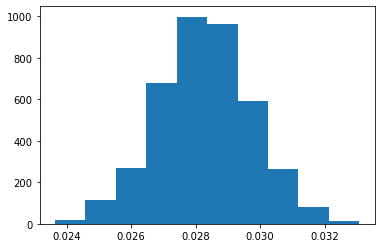

In [186]:
theta = second_fit.extract()['theta']
mean_theta = np.mean(theta)
mean_theta
_ = plt.hist(theta)

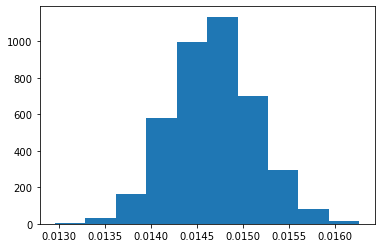

In [187]:
noise = second_fit.extract()['sigma']
mean_noise = np.mean(noise)
_ = plt.hist(noise)

### 1 day 

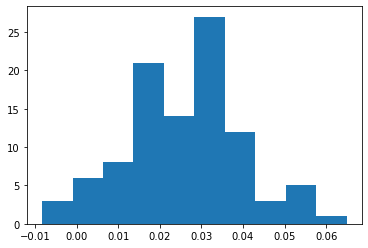

In [188]:
simulation_of_one_day = [simulate(mean_theta, mean_noise, 1) for i in range(100)]

_ = plt.hist(simulation_of_one_day)

In [189]:
np.mean(simulation_of_one_day),np.std(simulation_of_one_day) 

(0.02570951212927727, 0.013854281041567848)

$\theta = 0.026$

### 1 week

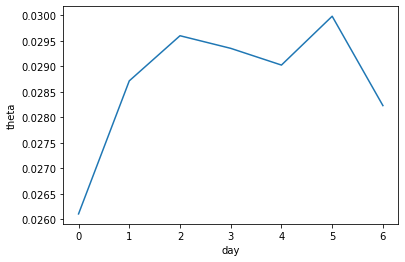

In [190]:
simulation_of_one_week = [simulate(mean_theta, mean_noise, 7) for i in range(100)]
plt.ylabel('theta')
plt.xlabel('day')
_ = plt.plot(np.mean(simulation_of_one_week, axis=0))

### 2 weeks

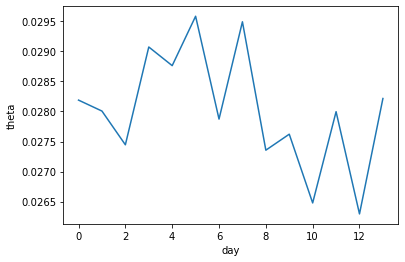

In [191]:
simulation_of_two_weeks = [simulate(mean_theta, mean_noise, 14) for i in range(100)]
plt.ylabel('theta')
plt.xlabel('day')
_ = plt.plot(np.mean(simulation_of_two_weeks, axis=0))

### this is example of ansewering the prediction question with two different models.
we can for example that the second models prediction are realy different at each simulation.
And it's not generalize well, because we clearly did an overfit.<br>
so the 3rd and last try will be to fit a Linear Regression.<br>
lets look at the data, as ratio points : 

### 3rd model linear regression

In [205]:
ratio = corona['positive'] / corona['tests']

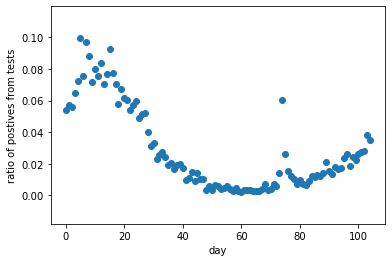

In [206]:
plt.scatter(corona.index,ratio)
plt.xlabel('day')
_ = plt.ylabel('ratio of postives from tests')

visually it's not look so linear in one variable. and we have only the variable of the day.
we will try to fit exponent with polynom paraboloid.<br>
(also tried with a line and -> it can't fit the increase in the end)

In [207]:
lr_model = """
data {
    int<lower=0> N;
    vector[N] x;
    vector[N] y;
}
parameters {
    real alpha;
    real beta;
    real gamma;
    real<lower=0> sigma;
}
model {
    y ~ lognormal(alpha + beta *x + gamma * square(x) , sigma);
}
"""

In [211]:
x = list(corona.index)
y = ratio

data = {'N': len(x), 'x': x, 'y': y}

In [212]:
compiled_lr_model = pystan.StanModel(model_code=lr_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ad6a642dbd47e063a66c2f30f321f6e3 NOW.


In [213]:
fit = compiled_lr_model.sampling(data=data, control = {'max_treedepth':15})
_ = print(fit)

Inference for Stan model: anon_model_ad6a642dbd47e063a66c2f30f321f6e3.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%   97.5%  n_eff   Rhat
alpha  -1.53  5.1e-3   0.16  -1.85  -1.64  -1.52  -1.42    -1.2   1037    1.0
beta   -0.11  2.2e-4 7.4e-3  -0.12  -0.11  -0.11   -0.1   -0.09   1169    1.0
gamma 8.6e-4  1.9e-6 6.9e-5 7.3e-4 8.2e-4 8.6e-4 9.1e-4 10.0e-4   1368    1.0
sigma   0.59  1.1e-3   0.04   0.52   0.56   0.59   0.62    0.68   1443    1.0
lp__    2.82    0.04   1.46  -0.95   2.13   3.13   3.88    4.61   1348    1.0

Samples were drawn using NUTS at Mon Aug  3 16:09:51 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


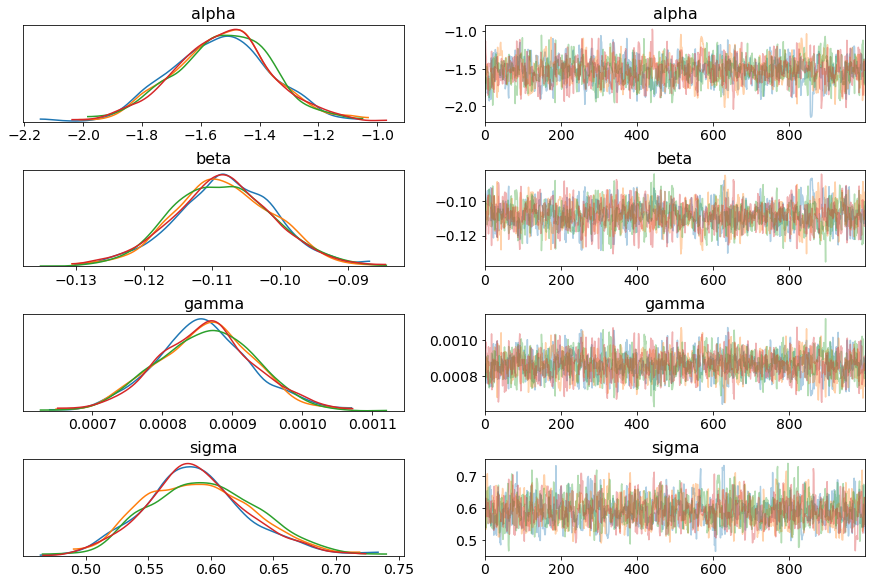

In [214]:
_ = arviz.plot_trace(fit)

In [215]:
alpha = fit['alpha']
beta = fit['beta']
gamma = fit['gamma']
sigma = fit['sigma']

In [216]:
def simulate_lr_without_noise(alpha,beta,gamma,x):
    return simulate_lr(alpha,beta,gamma,0,x)

In [217]:
def simulate_lr(alpha, beta, gamma, sigma, x):
    return np.random.lognormal(alpha+beta*x + gamma*x*x, sigma)

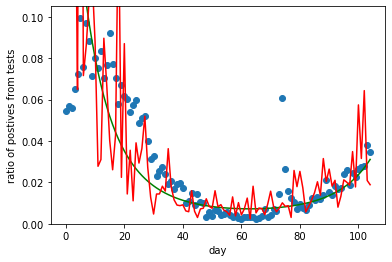

In [218]:
plt.scatter(x, y)
plt.xlabel('day')
plt.ylabel('ratio of postives from tests')
plt.ylim([0,0.105])
_ = plt.plot(x, simulate_lr_without_noise(np.mean(alpha),np.mean(beta),np.mean(gamma),np.array(x).astype(float)), color='g')
_ = plt.plot(x, simulate_lr(np.mean(alpha),np.mean(beta),np.mean(gamma), np.mean(sigma),np.array(x).astype(float)), color='r')

### 3rd model checking

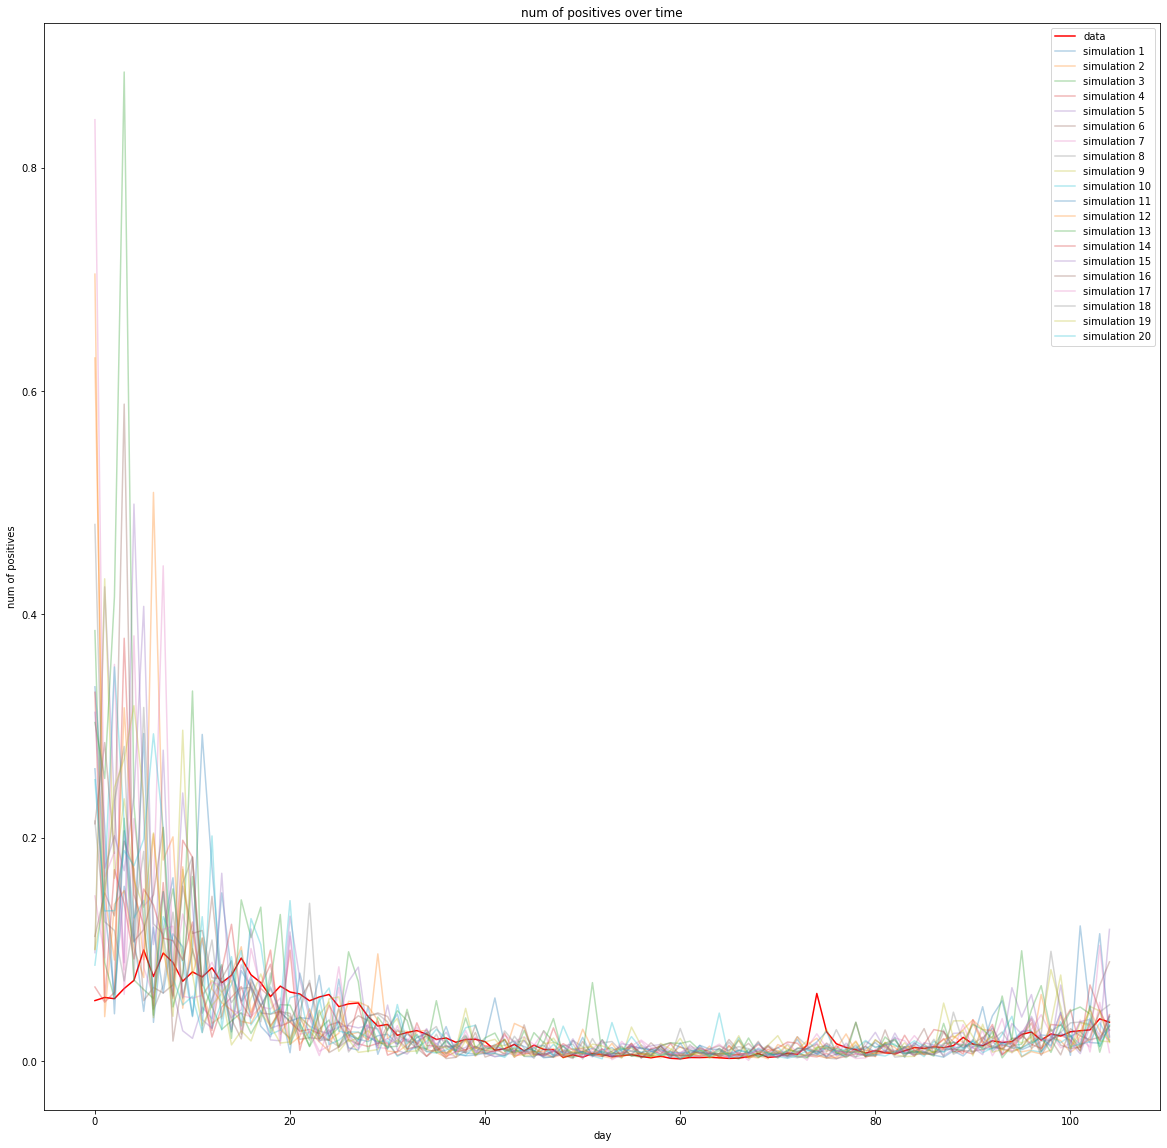

In [219]:
fig, ax = plt.subplots(figsize=(20,20))
ax.set_title('num of positives over time')
ax.set_xlabel("day")
ax.set_ylabel('num of positives')
ax.plot(ratio, label="data" , color='r')
for j in range(20):
    ax.plot(simulate_lr(np.mean(alpha),np.mean(beta), np.mean(gamma),np.mean(sigma),np.array(x).astype(float)), alpha=0.33, label="simulation "+str(j+1))
ax.legend()

In [220]:
dataMin, dataMax, dataMedian = ratio.min(), ratio.max(), np.median(ratio)
dataStd, dataMean = np.std(ratio) , np.mean(ratio)

In [221]:
NSIM = 300
fig, ax = plt.subplots(1, 5, figsize=(18, 9))
ax[0].set_xlabel("min")
ax[1].set_xlabel("max")
ax[2].set_xlabel("median")
ax[3].set_xlabel("std")
ax[4].set_xlabel("mean")
min_max_median_std_mean = []
for j in range(NSIM):
    y = simulate_lr(np.mean(alpha),np.mean(beta),np.mean(gamma), np.mean(sigma),np.array(x).astype(float))
    min_max_median_std_mean.append([y.min(), y.max(), np.median(y), np.std(y), np.mean(y)])
min_max_median_std_mean = np.array(min_max_median_std_mean)

# plot data values of test variables as vertical red lines
ax[0].axvline(dataMin, color="red")
ax[1].axvline(dataMax, color="red")
ax[2].axvline(dataMedian, color="red")
ax[3].axvline(dataStd, color="red")
ax[4].axvline(dataMean, color="red")
# plot sampled values of test values as histograms
for j in range(5):
    ax[j].hist(min_max_median_std_mean[:, j], zorder=-1)

# compute p-values and display them as subplot titles
ax[0].set_title("p-value = {:.2f}".format(
    len(min_max_median_std_mean[:, 0][min_max_median_std_mean[:, 0] < dataMin]) /
    len(min_max_median_std_mean)))
ax[1].set_title("p-value = {:.2f}".format(
    len(min_max_median_std_mean[:, 1][min_max_median_std_mean[:, 1] > dataMax]) /
    len(min_max_median_std_mean)))
ax[2].set_title("p-value = {:.2f}".format(
    len(min_max_median_std_mean[:, 2][min_max_median_std_mean[:, 2] < dataMedian]) /
    len(min_max_median_std_mean)))
ax[3].set_title("p-value = {:.2f}".format(
    len(min_max_median_std_mean[:, 3][min_max_median_std_mean[:, 3] < dataStd]) /
    len(min_max_median_std_mean)))
_ = ax[4].set_title("p-value = {:.2f}".format(
    len(min_max_median_std_mean[:, 4][min_max_median_std_mean[:, 4] < dataMean]) /
    len(min_max_median_std_mean)))

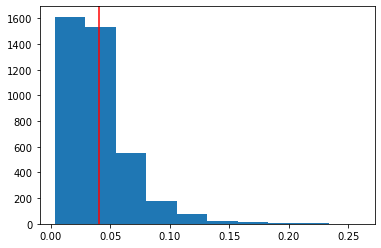

In [222]:
after_one_day_ratio = simulate_lr(alpha,beta,gamma,sigma, len(x))
plt.hist(after_one_day_ratio)
_ = plt.axvline(np.mean(after_one_day_ratio), color='r')

In [223]:
after_one_week_ratio = simulate_lr(alpha,beta,gamma,sigma,len(x)+7)
plt.hist(after_one_week_ratio, density =True)
plt.xlim([0,0.2])
_ = plt.axvline(np.mean(after_one_week_ratio), color='r')

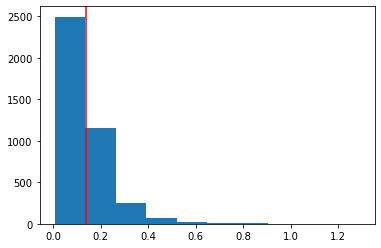

In [224]:
after_two_weeks_ratio = simulate_lr(alpha,beta,gamma,sigma,len(x)+14)
plt.hist(after_two_weeks_ratio)
_ = plt.axvline(np.mean(after_two_weeks_ratio), color='r')

answerting the research questions:

In [225]:
print(f'after one day:{np.mean(after_one_day_ratio)} ')
print(f'after one week:{np.mean(after_one_week_ratio)} ')
print(f'after two weeks:{np.mean(after_two_weeks_ratio)} ')

after one day:0.040723492212663304 
after one week:0.07129792538511463 
after two weeks:0.13667623880363788 


we can see that this model is more stable and has an element of tendency but it not catching the increasing afterwards

## Model Comparing

### we will compare 2nd and 3rd models. 
using lo cross-validation. due to the fact that i think the 2nd model overfitts and DIC benefits overfitted models

In [226]:
n_sim = 5
lppd = 0
x = list(corona.index)
for x_i in x:
    print(f'leave one out: {x_i}')
    # leave out x_i
    ratio_i =  corona.loc[x_i,'positive'] / corona.loc[x_i,'tests']
    updated_x = x[:]
    updated_x.remove(x_i)
    updated_data= corona.loc[updated_x]
    ratio = updated_data['positive'] / updated_data['tests']
    fit = compiled_lr_model.sampling(
        {'N':len(updated_data) , 'x':updated_x, 'y':ratio}, 
    control={'max_treedepth':15})
    alpha = fit['alpha']
    beta = fit['beta']
    gamma = fit['gamma']
    noise = fit['sigma']
    vals = np.random.randint(0, high=len(alpha), size=n_sim)
    alphas = alpha[vals]
    betas = beta[vals]
    noises = noise[vals]
    gammas = gamma[vals]
#     lr = np.random.lognormal(alphas+betas*x_i, noises)
 #   scipy.stats.lognormal.pdf(ratio_i,alphas+betas*x_i, noises )
    # different paramatization
    s = noises
    scale = np.exp(alphas+betas*x_i + gammas*x_i*x_i)
    pdfs = scipy.stats.lognorm.pdf(ratio_i, s, 0, scale)
#    print(f'shape: {pdfs.shape}sum: {pdfs.sum()} mean: {np.mean(pdfs)}')
    #     lr_vals = simulate_lr(alpha,beta,noise, x_i)
    lppd += np.log(pdfs.sum()/n_sim)
print(-2*lppd)

leave one out: 0
leave one out: 1
leave one out: 2
leave one out: 3
leave one out: 4
leave one out: 5
leave one out: 6
leave one out: 7
leave one out: 8
leave one out: 9
leave one out: 10
leave one out: 11
leave one out: 12
leave one out: 13
leave one out: 14
leave one out: 15
leave one out: 16
leave one out: 17
leave one out: 18
leave one out: 19
leave one out: 20
leave one out: 21
leave one out: 22
leave one out: 23
leave one out: 24
leave one out: 25
leave one out: 26
leave one out: 27
leave one out: 28
leave one out: 29
leave one out: 30
leave one out: 31
leave one out: 32
leave one out: 33
leave one out: 34
leave one out: 35
leave one out: 36
leave one out: 37
leave one out: 38
leave one out: 39
leave one out: 40
leave one out: 41
leave one out: 42
leave one out: 43
leave one out: 44
leave one out: 45
leave one out: 46
leave one out: 47
leave one out: 48
leave one out: 49
leave one out: 50
leave one out: 51
leave one out: 52
leave one out: 53
leave one out: 54
leave one out: 55
le

In [228]:
n_sim = 5
lppd = 0
x = list(corona.index)
for x_i in x:
    print(f'leave one out: {x_i}')
    ratio_i =  corona.loc[x_i,'positive'] / corona.loc[x_i,'tests']
    # leave out x_i
    updated_x = x[:]
    updated_x.remove(x_i)
    updated_data= corona.loc[updated_x]
    p = updated_data['positive']
    t = updated_data['tests']
    fit = compiled_model.sampling(
        {'N':len(updated_data) , 'p':p, 't':t})
    mu = fit['theta']
    sigma = fit['sigma']
    vals = np.random.randint(0, high=len(mu), size=n_sim)
    mus = mu[vals]
    sigmas = sigma[vals]
    pdfs = scipy.stats.norm.pdf(ratio_i, mus, sigmas)
#    print(f'sum: {pdfs.sum()} mean: {np.mean(pdfs)}')
    lppd += np.log(pdfs.sum()/n_sim)
print(-2*lppd)

leave one out: 0


leave one out: 1
leave one out: 2
leave one out: 3
leave one out: 4
leave one out: 5
leave one out: 6
leave one out: 7


leave one out: 8


leave one out: 9


leave one out: 10
leave one out: 11
leave one out: 12
leave one out: 13


leave one out: 14
leave one out: 15
leave one out: 16
leave one out: 17


leave one out: 18


leave one out: 19


leave one out: 20


leave one out: 21
leave one out: 22


leave one out: 23


leave one out: 24
leave one out: 25
leave one out: 26
leave one out: 27


leave one out: 28


leave one out: 29
leave one out: 30


leave one out: 31
leave one out: 32
leave one out: 33
leave one out: 34


leave one out: 35
leave one out: 36
leave one out: 37


leave one out: 38
leave one out: 39
leave one out: 40
leave one out: 41


leave one out: 42


leave one out: 43


leave one out: 44


leave one out: 45
leave one out: 46
leave one out: 47
leave one out: 48
leave one out: 49
leave one out: 50
leave one out: 51


leave one out: 52
leave one out: 53


leave one out: 54


leave one out: 55
leave one out: 56


leave one out: 57


leave one out: 58


leave one out: 59
leave one out: 60


leave one out: 61


leave one out: 62
leave one out: 63
leave one out: 64


leave one out: 65
leave one out: 66
leave one out: 67
leave one out: 68
leave one out: 69
leave one out: 70
leave one out: 71
leave one out: 72
leave one out: 73
leave one out: 74
leave one out: 75


leave one out: 76
leave one out: 77
leave one out: 78


leave one out: 79


leave one out: 80
leave one out: 81
leave one out: 82


leave one out: 83
leave one out: 84


leave one out: 85
leave one out: 86
leave one out: 87


leave one out: 88


leave one out: 89


leave one out: 90
leave one out: 91
leave one out: 92
leave one out: 93
leave one out: 94
leave one out: 95
leave one out: 96


leave one out: 97


leave one out: 98


leave one out: 99


leave one out: 100
leave one out: 101


leave one out: 102
leave one out: 103


leave one out: 104


-333.1574868691487


we can see that the linear regression model results are better<br> The 2nd model is clearly overfittet<br>. 
The lr model has a clear benfit that it's models the connection between days and visually it looks good.
the use of lognormal instead of normal gurentess that the results are positived and models that y is exponential.

summery:<br>
the first two models are not modeling good the data and therefore the results are low.
the third model models the data most realistcly (we can see it visually in the notebook) and probably is prediction are most valueble. it's also did better in the cross validation  test.<br>
all the answers embedded in the notebook